## Setup the Env


In [1]:
import os
import sys

import sagemaker
from sagemaker import get_execution_role

# Add the parent directory to the sys.path
sys.path.insert(0, os.path.abspath(".."))

# Define IAM role
role = get_execution_role()
role

# Establish S3 bucket connection
import boto3

s3 = boto3.client("s3")
bucket = "capstone-bucket-4-friends"

# Take a look at current dir
print(os.getcwd())

from file_utilities import s3_download

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
/home/sagemaker-user/capstone-2024-summer/src/shuo


## Import Package

In [2]:
!pip install seaborn
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import joblib
import time
import logging
import torch.distributions as dist
from sklearn.preprocessing import StandardScaler


warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

In [3]:
# pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113


In [4]:
torch.cuda.is_available()


True

In [5]:
import torch
import torch.nn as nn

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

# Example model
model = nn.Linear(10, 2)

# Move model to the device (GPU if available)
model.to(device)

# Example data
x = torch.randn(1, 10).to(device)
output = model(x)
print(output)


CUDA is available. Using GPU.
tensor([[-0.3388,  0.2372]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Load Data

In [7]:
# reload_path = s3_download("CRSP/crsp_2018-2023_clean_3.parquet")
# reload_path

In [8]:
os.getcwd()

'/home/sagemaker-user/capstone-2024-summer/src/shuo'

In [9]:
!pwd

/home/sagemaker-user/capstone-2024-summer/src/shuo


In [10]:
df = pd.read_parquet("../../data/crsp_2018-2023_clean_3.parquet")

In [11]:
df

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,primary_exchange,trading_status,security_status,naics,naics_sector,naics_sector_name,naics_secondary,ask_or_high_price,ask_price,bid_or_low_price,bid_price,open_price,close_price,return,volume,shares_outstanding,num_trades,factor_to_adjust_price,factor_to_adjust_shares,value_weighted_return,equal_weighted_return,return_on_SP_index,log_return,abs_log_return,market_cap,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,price_7,return_7,log_return_7,abs_log_return_7,price_14,return_14,log_return_14,abs_log_return_14,price_28,return_28,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
9263,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,N,A,R,511210.0,51,Information,1210.0,47.8011,46.63000,46.17000,46.62000,47.57000,46.63000,-0.013748,25380018,4139602,99,1.0,1.0,0.008505,0.011232,0.008303,-0.013843,0.013843,1.930296e+08,0.000000,0.000000,0.000000,0.000000,48.95,4.743043,0.309424,0.309424,51.12,4.231880,0.131071,0.131071,48.15,0.334682,0.011619,0.011619,0.136136,0.109282,0.276310
9264,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,N,A,R,511210.0,51,Information,1210.0,48.0700,47.71000,47.44000,47.70000,47.53000,47.71000,0.023161,24165000,4139602,99,1.0,1.0,0.005856,0.005103,0.006399,0.022897,0.022897,1.975004e+08,0.006404,0.004872,0.005904,0.007983,49.51,2.793205,0.234088,0.234088,51.45,2.890159,0.107382,0.107382,48.49,0.157137,0.006475,0.006475,0.091648,0.081082,0.268724
9265,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,N,A,R,511210.0,51,Information,1210.0,48.1900,48.18000,47.71500,48.17000,47.99000,48.18000,0.009851,19815057,4139602,99,1.0,1.0,0.004001,0.005272,0.004029,0.009803,0.009803,1.994460e+08,0.004048,0.000960,0.004021,0.000852,49.59,1.824771,0.183199,0.183199,51.60,2.436310,0.097613,0.097613,49.45,0.263850,0.009651,0.009651,0.089939,0.079524,0.273385
9266,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,N,A,R,511210.0,51,Information,1210.0,48.6300,48.45000,48.28000,48.44000,48.42000,48.47000,0.006019,14496427,4139602,99,1.0,1.0,0.005804,0.003880,0.007034,0.006001,0.006001,2.006465e+08,0.009581,0.006722,0.006193,0.002919,50.27,2.716132,0.230474,0.230474,52.75,3.586591,0.120486,0.120486,50.64,0.483153,0.015437,0.015437,0.105015,0.107098,0.281463
9267,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,N,A,R,511210.0,51,Information,1210.0,49.0700,48.99000,47.94000,48.98000,48.30000,48.98000,0.010522,15075007,4139602,99,1.0,1.0,0.001816,0.000584,0.001662,0.010467,0.010467,2.027577e+08,0.002142,0.005354,0.001829,0.005828,50.23,1.477412,0.161223,0.161223,51.94,1.875391,0.083731,0.083731,50.71,0.366701,0.012476,0.012476,0.105560,0.139328,0.280139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7656951,2023-12-22,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,Q,A,R,336110.0,33,Manufacturing,6110.0,258.2200,252.53999,251.37000,252.53000,256.76001,252.53999,-0.007701,93148541,3178921,972876,1.0,1.0,0.002440,0.007676,0.001660,-0.007731,0.007731,8.028047e+08,0.000259,0.007069,0.002502,0.004469,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656952,2023-12-26,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,Q,A,R,336110.0,33,Manufacturing,6110.0,257.9700,256.70999,252.91000,256.66000,254.49001,256.60999,0.016116,86700724,3178921,954492,1.0,1.0,0.005218,0.009674,0.004232,0.015988,0.015988,8.157429e+08,0.007335,0.009616,0.005189,0.003873,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656953,2023-12-27,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,Q,

In [12]:
df.dtypes

date                              datetime64[ns]
permno_id                                 object
ncusip_id                                 object
cusip_id                                  object
ticker                                    object
share_code                                object
share_code_type                           object
share_code_detail                         object
exchange_code                             object
company_name                              object
primary_exchange                          object
trading_status                            object
security_status                           object
naics                                     object
naics_sector                              object
naics_sector_name                         object
naics_secondary                           object
ask_or_high_price                        float64
ask_price                                float64
bid_or_low_price                         float64
bid_price           

## Feature Engineering

### Feature Selection

In [39]:
data = df[
    [
        "date",
        "permno_id",
        # "naics",
        "log_return",
        "abs_log_return",
        "sector_weighted_avg_log_return",
        "sector_simple_avg_log_return",
        "weighted_avg_log_return",
        "simple_avg_log_return",
        "log_return_7",
        "abs_log_return_7",
        "log_return_14",
        "abs_log_return_14",
        "log_return_28",
        "abs_log_return_28",
        "volatility_7",
        "volatility_14",
        "volatility_28",
    ]
].copy()
data

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
9263,2018-01-02,10104,-0.013843,0.013843,0.000000,0.000000,0.000000,0.000000,0.309424,0.309424,0.131071,0.131071,0.011619,0.011619,0.136136,0.109282,0.276310
9264,2018-01-03,10104,0.022897,0.022897,0.006404,0.004872,0.005904,0.007983,0.234088,0.234088,0.107382,0.107382,0.006475,0.006475,0.091648,0.081082,0.268724
9265,2018-01-04,10104,0.009803,0.009803,0.004048,0.000960,0.004021,0.000852,0.183199,0.183199,0.097613,0.097613,0.009651,0.009651,0.089939,0.079524,0.273385
9266,2018-01-05,10104,0.006001,0.006001,0.009581,0.006722,0.006193,0.002919,0.230474,0.230474,0.120486,0.120486,0.015437,0.015437,0.105015,0.107098,0.281463
9267,2018-01-08,10104,0.010467,0.010467,0.002142,0.005354,0.001829,0.005828,0.161223,0.161223,0.083731,0.083731,0.012476,0.012476,0.105560,0.139328,0.280139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7656951,2023-12-22,93436,-0.007731,0.007731,0.000259,0.007069,0.002502,0.004469,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656952,2023-12-26,93436,0.015988,0.015988,0.007335,0.009616,0.005189,0.003873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656953,2023-12-27,93436,0.018647,0.018647,0.002344,0.001393,0.001653,0.001163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656954,2023-12-28,93436,-0.032104,0.032104,-0.001451,-0.000214,-0.000266,0.002184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Standardize features and labels

In [40]:
columns = [
    "log_return",
    "sector_weighted_avg_log_return",
    "sector_simple_avg_log_return",
    "weighted_avg_log_return",
    "simple_avg_log_return",
    "abs_log_return",
    "log_return_7",
    "abs_log_return_7",
    "log_return_14",
    "abs_log_return_14",
    "log_return_28",
    "abs_log_return_28",
    "volatility_7",
    "volatility_14",
    "volatility_28",
]
scaler = StandardScaler()

data[columns] =scaler.fit_transform(data[columns])
data

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
9263,2018-01-02,10104,-0.599913,-0.077145,-0.018430,-0.009147,-0.025258,-0.017993,0.511707,0.201900,1.097317,0.702858,0.215318,-0.548049,-0.716988,-0.942127,-0.192751
9264,2018-01-03,10104,0.953274,0.423184,0.328289,0.302093,0.420004,0.618797,0.355892,0.028348,0.879456,0.403960,0.079349,-0.737177,-0.911900,-1.074948,-0.230518
9265,2018-01-04,10104,0.399725,-0.300443,0.200733,0.052181,0.277994,0.049970,0.250640,-0.088885,0.789610,0.280693,0.163295,-0.620411,-0.919385,-1.082285,-0.207312
9266,2018-01-05,10104,0.239003,-0.510547,0.500294,0.420277,0.441800,0.214851,0.348418,0.020023,0.999965,0.569295,0.316238,-0.407673,-0.853336,-0.952413,-0.167097
9267,2018-01-08,10104,0.427805,-0.263735,0.097540,0.332884,0.112680,0.446897,0.205187,-0.139512,0.661939,0.105531,0.237967,-0.516545,-0.850950,-0.800611,-0.173688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7656951,2023-12-22,93436,-0.341505,-0.414949,-0.004407,0.442444,0.163436,0.338492,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281
7656952,2023-12-26,93436,0.661183,0.041348,0.378694,0.605155,0.366081,0.290950,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281
7656953,2023-12-27,93436,0.773615,0.188324,0.108477,0.079842,0.099407,0.074778,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281
7656954,2023-12-28,93436,-1.371871,0.931997,-0.096988,-0.022818,-0.045319,0.156221,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281


### Select number of stocks

In [41]:
data['permno_id'].nunique()

554

In [42]:
# Function to filter the first n stocks
def filter_first_n_stocks(data, n):
    first_n_permno_ids = data["permno_id"].unique()[:n]
    return data[data["permno_id"].isin(first_n_permno_ids)]

In [43]:
# Filter the first n stocks
n_stocks = 10  # Adjust n as needed
data = filter_first_n_stocks(data, n_stocks)
data

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
9263,2018-01-02,10104,-0.599913,-0.077145,-0.018430,-0.009147,-0.025258,-0.017993,0.511707,0.201900,1.097317,0.702858,0.215318,-0.548049,-0.716988,-0.942127,-0.192751
9264,2018-01-03,10104,0.953274,0.423184,0.328289,0.302093,0.420004,0.618797,0.355892,0.028348,0.879456,0.403960,0.079349,-0.737177,-0.911900,-1.074948,-0.230518
9265,2018-01-04,10104,0.399725,-0.300443,0.200733,0.052181,0.277994,0.049970,0.250640,-0.088885,0.789610,0.280693,0.163295,-0.620411,-0.919385,-1.082285,-0.207312
9266,2018-01-05,10104,0.239003,-0.510547,0.500294,0.420277,0.441800,0.214851,0.348418,0.020023,0.999965,0.569295,0.316238,-0.407673,-0.853336,-0.952413,-0.167097
9267,2018-01-08,10104,0.427805,-0.263735,0.097540,0.332884,0.112680,0.446897,0.205187,-0.139512,0.661939,0.105531,0.237967,-0.516545,-0.850950,-0.800611,-0.173688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128889,2023-12-22,11404,0.207433,-0.551817,0.217354,0.359332,0.163436,0.338492,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281
128890,2023-12-26,11404,0.262529,-0.479793,0.332728,0.410886,0.366081,0.290950,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281
128891,2023-12-27,11404,-0.235386,-0.553672,-0.079500,-0.151032,0.099407,0.074778,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281
128892,2023-12-28,11404,0.383563,-0.321571,0.236195,0.117214,-0.045319,0.156221,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281


### Remove Stock with less than 1500 dates' data

In [44]:
data.groupby('permno_id').nunique()

,date,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
permno_id,,,,,,,,,,,,,,,,
10104,1509,1494,1494,1483,1490,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10107,1509,1491,1491,1482,1489,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10138,1509,1490,1490,1480,1480,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10145,1509,1477,1477,1477,1480,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10516,1509,1482,1482,1480,1467,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10696,1509,1477,1477,1482,1489,1482,1484,1502,1502,1496,1496,1482,1482,1502,1496,1482
10909,1117,1086,1086,1102,1105,1103,1103,1111,1111,1104,1104,1090,1090,1111,1104,1090
11308,1509,1467,1467,1480,1467,1482,1484,1502,1502,1496,1496,1481,1481,1502,1496,1481
11403,1509,1494,1494,1475,1481,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482


In [45]:
grouped_data = data.groupby('permno_id')['date'].nunique().reset_index()
grouped_data.columns = ['permno_id', 'date_count']

filtered_permno_ids = grouped_data[grouped_data['date_count'] > 1500]['permno_id']
filtered_permno_ids
data = data[data['permno_id'].isin(filtered_permno_ids)]
data

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
9263,2018-01-02,10104,-0.599913,-0.077145,-0.018430,-0.009147,-0.025258,-0.017993,0.511707,0.201900,1.097317,0.702858,0.215318,-0.548049,-0.716988,-0.942127,-0.192751
9264,2018-01-03,10104,0.953274,0.423184,0.328289,0.302093,0.420004,0.618797,0.355892,0.028348,0.879456,0.403960,0.079349,-0.737177,-0.911900,-1.074948,-0.230518
9265,2018-01-04,10104,0.399725,-0.300443,0.200733,0.052181,0.277994,0.049970,0.250640,-0.088885,0.789610,0.280693,0.163295,-0.620411,-0.919385,-1.082285,-0.207312
9266,2018-01-05,10104,0.239003,-0.510547,0.500294,0.420277,0.441800,0.214851,0.348418,0.020023,0.999965,0.569295,0.316238,-0.407673,-0.853336,-0.952413,-0.167097
9267,2018-01-08,10104,0.427805,-0.263735,0.097540,0.332884,0.112680,0.446897,0.205187,-0.139512,0.661939,0.105531,0.237967,-0.516545,-0.850950,-0.800611,-0.173688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128889,2023-12-22,11404,0.207433,-0.551817,0.217354,0.359332,0.163436,0.338492,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281
128890,2023-12-26,11404,0.262529,-0.479793,0.332728,0.410886,0.366081,0.290950,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281
128891,2023-12-27,11404,-0.235386,-0.553672,-0.079500,-0.151032,0.099407,0.074778,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281
128892,2023-12-28,11404,0.383563,-0.321571,0.236195,0.117214,-0.045319,0.156221,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281


In [46]:
data.groupby('permno_id').nunique()

,date,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
permno_id,,,,,,,,,,,,,,,,
10104,1509,1494,1494,1483,1490,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10107,1509,1491,1491,1482,1489,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10138,1509,1490,1490,1480,1480,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10145,1509,1477,1477,1477,1480,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10516,1509,1482,1482,1480,1467,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10696,1509,1477,1477,1482,1489,1482,1484,1502,1502,1496,1496,1482,1482,1502,1496,1482
11308,1509,1467,1467,1480,1467,1482,1484,1502,1502,1496,1496,1481,1481,1502,1496,1481
11403,1509,1494,1494,1475,1481,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
11404,1509,1472,1472,1471,1483,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482


In [47]:
# data["naics_sector_digits"] = data["naics"].astype(str).str[:2]
# data

### Add positional_encoding

In [48]:
# data["positional_encoding"] = data.groupby("permno_id").cumcount() + 1
# data

In [49]:
def create_rolling_features_with_positional_encoding(data, input_columns, target_columns, window_size):
    # Sort data by permno_id and date
    data = data.sort_values(by=["permno_id", "date"])

    # Create rolling window features for each group of permno_id
    for col in input_columns:
        for i in range(1, window_size + 1):
            data[f"{col}_past_{i}"] = data.groupby("permno_id")[col].shift(i)

    # # Add positional encoding
    # data["positional_encoding"] = data.groupby("permno_id").cumcount() + 1

    # Drop rows with NaN values created by the shift operation
    data = data.dropna()

    return data

In [50]:
# Input parameters
input_columns = [
    "log_return",
    # "sector_weighted_avg_log_return",
    # "sector_simple_avg_log_return",
    # "weighted_avg_log_return",
    # "simple_avg_log_return",
]
target_columns = [
    "log_return",
    "abs_log_return",
    "log_return_7",
    "abs_log_return_7",
    "log_return_14",
    "abs_log_return_14",
    "log_return_28",
    "abs_log_return_28",
    "volatility_7",
    "volatility_14",
    "volatility_28",
]

window_size = 128

In [51]:
data = create_rolling_features_with_positional_encoding(data, input_columns, target_columns, window_size)
data

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28,log_return_past_1,log_return_past_2,log_return_past_3,log_return_past_4,log_return_past_5,log_return_past_6,log_return_past_7,log_return_past_8,log_return_past_9,log_return_past_10,log_return_past_11,log_return_past_12,log_return_past_13,log_return_past_14,log_return_past_15,log_return_past_16,log_return_past_17,log_return_past_18,log_return_past_19,log_return_past_20,log_return_past_21,log_return_past_22,log_return_past_23,log_return_past_24,log_return_past_25,log_return_past_26,log_return_past_27,log_return_past_28,log_return_past_29,log_return_past_30,log_return_past_31,log_return_past_32,log_return_past_33,log_return_past_34,log_return_past_35,log_return_past_36,log_return_past_37,log_return_past_38,log_return_past_39,log_return_past_40,log_return_past_41,log_return_past_42,log_return_past_43,log_return_past_44,log_return_past_45,log_return_past_46,log_return_past_47,log_return_past_48,log_return_past_49,log_return_past_50,log_return_past_51,log_return_past_52,log_return_past_53,log_return_past_54,log_return_past_55,log_return_past_56,log_return_past_57,log_return_past_58,log_return_past_59,log_return_past_60,log_return_past_61,log_return_past_62,log_return_past_63,log_return_past_64,log_return_past_65,log_return_past_66,log_return_past_67,log_return_past_68,log_return_past_69,log_return_past_70,log_return_past_71,log_return_past_72,log_return_past_73,log_return_past_74,log_return_past_75,log_return_past_76,log_return_past_77,log_return_past_78,log_return_past_79,log_return_past_80,log_return_past_81,log_return_past_82,log_return_past_83,log_return_past_84,log_return_past_85,log_return_past_86,log_return_past_87,log_return_past_88,log_return_past_89,log_return_past_90,log_return_past_91,log_return_past_92,log_return_past_93,log_return_past_94,log_return_past_95,log_return_past_96,log_return_past_97,log_return_past_98,log_return_past_99,log_return_past_100,log_return_past_101,log_return_past_102,log_return_past_103,log_return_past_104,log_return_past_105,log_return_past_106,log_return_past_107,log_return_past_108,log_return_past_109,log_return_past_110,log_return_past_111,log_return_past_112,log_return_past_113,log_return_past_114,log_return_past_115,log_return_past_116,log_return_past_117,log_return_past_118,log_return_past_119,log_return_past_120,log_return_past_121,log_return_past_122,log_return_past_123,log_return_past_124,log_return_past_125,log_return_past_126,log_return_past_127,log_return_past_128
9391,2018-07-06,10104,0.531053,-0.128765,0.703972,0.861647,0.625893,0.224981,0.693460,0.404344,0.686261,0.138900,0.277221,-0.461943,-0.958115,-0.967099,-0.945301,0.632591,-0.231562,0.830754,0.196918,0.363080,-0.938563,0.109251,0.157528,0.954968,0.260849,-3.290483,-0.242484,0.203984,0.333866,-2.143026,-0.172030,0.212773,-0.005894,0.426341,-0.076707,0.537813,-0.184761,-0.041497,0.551580,-0.312247,0.701146,-0.685599,0.473840,-0.413181,0.465774,-0.773654,0.789877,-0.214993,-0.186926,-0.086996,-0.023734,-0.014686,-0.113895,0.301779,0.570180,-0.134155,0.316966,0.590771,-0.434780,-0.421461,0.243709,0.115109,-0.412071,0.178911,0.189094,-0.264634,-0.409724,-0.550776,-0.248817,0.364127,0.541610,0.131838,0.169189,0.234843,-0.208877,0.842770,0.051253,-1.067089,0.401274,0.565218,-0.127541,-0.704072,0.702892,-0.388948,-1.027191,1.551070,-1.040356,-1.043042,-0.041666,-4.202867,-0.274288,-0.095466,0.025709,-0.224254,-0.271183,-0.070568,0.661100,0.319105,0.165527,0.158033,0.792490,0.500911,-0.823309,-0.064727,-0.379779,0.542486,0.754025,0.121936,-0.406268,-0.703857,0.043697,0.990609,0.814093,0.282767,0.355705,0.781041,-1.808255,-0.470704,1.121516,-1.771001,-1.261091,0.018064,0.504753,-0.819949,-0.668851,0.917147,0.108366,0.257321,0.325731,0.093821,0.278863,-0.04

In [52]:
data.columns

Index(['date', 'permno_id', 'log_return', 'abs_log_return',
       'sector_weighted_avg_log_return', 'sector_simple_avg_log_return',
       'weighted_avg_log_return', 'simple_avg_log_return', 'log_return_7',
       'abs_log_return_7',
       ...
       'log_return_past_119', 'log_return_past_120', 'log_return_past_121',
       'log_return_past_122', 'log_return_past_123', 'log_return_past_124',
       'log_return_past_125', 'log_return_past_126', 'log_return_past_127',
       'log_return_past_128'],
      dtype='object', length=145)

### Check inf and missing values

In [53]:
# def check_data(df):
#     if df.isnull().values.any():
#         print("Data contains NaNs")
#     if np.isinf(pd.to_numeric(df.stack(), errors="coerce")).any():
#         print("Data contains Infinities")


# check_data(data)

In [54]:
data[-30:]

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28,log_return_past_1,log_return_past_2,log_return_past_3,log_return_past_4,log_return_past_5,log_return_past_6,log_return_past_7,log_return_past_8,log_return_past_9,log_return_past_10,log_return_past_11,log_return_past_12,log_return_past_13,log_return_past_14,log_return_past_15,log_return_past_16,log_return_past_17,log_return_past_18,log_return_past_19,log_return_past_20,log_return_past_21,log_return_past_22,log_return_past_23,log_return_past_24,log_return_past_25,log_return_past_26,log_return_past_27,log_return_past_28,log_return_past_29,log_return_past_30,log_return_past_31,log_return_past_32,log_return_past_33,log_return_past_34,log_return_past_35,log_return_past_36,log_return_past_37,log_return_past_38,log_return_past_39,log_return_past_40,log_return_past_41,log_return_past_42,log_return_past_43,log_return_past_44,log_return_past_45,log_return_past_46,log_return_past_47,log_return_past_48,log_return_past_49,log_return_past_50,log_return_past_51,log_return_past_52,log_return_past_53,log_return_past_54,log_return_past_55,log_return_past_56,log_return_past_57,log_return_past_58,log_return_past_59,log_return_past_60,log_return_past_61,log_return_past_62,log_return_past_63,log_return_past_64,log_return_past_65,log_return_past_66,log_return_past_67,log_return_past_68,log_return_past_69,log_return_past_70,log_return_past_71,log_return_past_72,log_return_past_73,log_return_past_74,log_return_past_75,log_return_past_76,log_return_past_77,log_return_past_78,log_return_past_79,log_return_past_80,log_return_past_81,log_return_past_82,log_return_past_83,log_return_past_84,log_return_past_85,log_return_past_86,log_return_past_87,log_return_past_88,log_return_past_89,log_return_past_90,log_return_past_91,log_return_past_92,log_return_past_93,log_return_past_94,log_return_past_95,log_return_past_96,log_return_past_97,log_return_past_98,log_return_past_99,log_return_past_100,log_return_past_101,log_return_past_102,log_return_past_103,log_return_past_104,log_return_past_105,log_return_past_106,log_return_past_107,log_return_past_108,log_return_past_109,log_return_past_110,log_return_past_111,log_return_past_112,log_return_past_113,log_return_past_114,log_return_past_115,log_return_past_116,log_return_past_117,log_return_past_118,log_return_past_119,log_return_past_120,log_return_past_121,log_return_past_122,log_return_past_123,log_return_past_124,log_return_past_125,log_return_past_126,log_return_past_127,log_return_past_128
128864,2023-11-16,11404,0.255220,-0.489347,0.162347,0.099774,-0.125864,0.310174,-0.166477,-0.468362,0.062227,-0.717258,-0.136639,-0.912868,-1.049837,-0.927066,-0.775208,0.008685,1.368865,-0.480918,0.032635,0.256187,-0.394365,-0.512560,0.205330,-0.056898,0.456829,0.639918,0.134871,-0.009867,-0.890024,0.456620,0.148391,0.653735,-0.243546,-0.309863,-0.307819,-0.310544,0.099597,0.291582,0.298674,-0.534039,0.143337,0.259673,0.568762,0.771000,0.265553,0.500577,0.785688,-1.992848,0.005094,-0.574673,-0.596269,-1.154380,-0.294880,-0.028639,-0.311438,0.138072,-0.199747,0.022246,-0.423936,0.408432,0.571764,0.206171,0.212058,0.337304,0.810031,0.126782,-0.904399,-0.305563,-0.426113,-0.132162,0.159297,-0.094704,0.183329,-0.287902,0.296324,0.303416,-0.304371,0.494813,-0.291604,0.536185,-0.522785,-0.609944,0.181226,-0.271098,-0.121438,0.250389,0.600897,-0.494769,-1.395888,-0.019210,-0.697584,-0.360893,-0.063288,-0.780369,-0.105633,0.236986,-0.014686,0.528465,1.056855,0.600230,-0.142973,-0.315525,-0.326894,0.293009,0.235809,0.513939,-0.309692,-0.078951,-0.325446,0.812891,0.288182,0.375270,-0.268802,-0.883033,0.123411,0.420986,-0.652797,-0.380249,0.396753,-0.448872,-0.037394,0.272607,0.150370,-0.289391,-0.405372,-0.244694,0.192712,0.499115,-0.261019,0.530051,-0.0

In [55]:
# data.describe().T

In [56]:
# # Check if there are any infinite values in the entire DataFrame
# infinite_values = data.isin([np.inf, -np.inf]).values.any()
# print(f"Data contains Infinities: {infinite_values}")

# # Check for specific columns
# column_with_inf = data.isin([np.inf, -np.inf]).any()
# print("Columns with Infinities:")
# print(column_with_inf[column_with_inf].index.tolist())

In [57]:
# data_inf_rows = data[(data == np.inf) | (data == -np.inf)].any(axis=1)
# data[data_inf_rows]

### Remove last 28 rows

In [58]:
# Define a function to remove the last 28 rows for each permno_id
def remove_last_n_rows(df, n):
    # Group by 'permno_id'
    groups = df.groupby("permno_id")
    # Remove last n rows for each group
    df_cleaned = groups.apply(lambda x: x.iloc[:-n] if len(x) > n else x)
    # Remove the extra groupby level
    df_cleaned.reset_index(drop=True, inplace=True)
    return df_cleaned

In [59]:
# Remove the last 28 rows for each permno_id
cleaned_data = remove_last_n_rows(data, 28)
cleaned_data[-30:]

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28,log_return_past_1,log_return_past_2,log_return_past_3,log_return_past_4,log_return_past_5,log_return_past_6,log_return_past_7,log_return_past_8,log_return_past_9,log_return_past_10,log_return_past_11,log_return_past_12,log_return_past_13,log_return_past_14,log_return_past_15,log_return_past_16,log_return_past_17,log_return_past_18,log_return_past_19,log_return_past_20,log_return_past_21,log_return_past_22,log_return_past_23,log_return_past_24,log_return_past_25,log_return_past_26,log_return_past_27,log_return_past_28,log_return_past_29,log_return_past_30,log_return_past_31,log_return_past_32,log_return_past_33,log_return_past_34,log_return_past_35,log_return_past_36,log_return_past_37,log_return_past_38,log_return_past_39,log_return_past_40,log_return_past_41,log_return_past_42,log_return_past_43,log_return_past_44,log_return_past_45,log_return_past_46,log_return_past_47,log_return_past_48,log_return_past_49,log_return_past_50,log_return_past_51,log_return_past_52,log_return_past_53,log_return_past_54,log_return_past_55,log_return_past_56,log_return_past_57,log_return_past_58,log_return_past_59,log_return_past_60,log_return_past_61,log_return_past_62,log_return_past_63,log_return_past_64,log_return_past_65,log_return_past_66,log_return_past_67,log_return_past_68,log_return_past_69,log_return_past_70,log_return_past_71,log_return_past_72,log_return_past_73,log_return_past_74,log_return_past_75,log_return_past_76,log_return_past_77,log_return_past_78,log_return_past_79,log_return_past_80,log_return_past_81,log_return_past_82,log_return_past_83,log_return_past_84,log_return_past_85,log_return_past_86,log_return_past_87,log_return_past_88,log_return_past_89,log_return_past_90,log_return_past_91,log_return_past_92,log_return_past_93,log_return_past_94,log_return_past_95,log_return_past_96,log_return_past_97,log_return_past_98,log_return_past_99,log_return_past_100,log_return_past_101,log_return_past_102,log_return_past_103,log_return_past_104,log_return_past_105,log_return_past_106,log_return_past_107,log_return_past_108,log_return_past_109,log_return_past_110,log_return_past_111,log_return_past_112,log_return_past_113,log_return_past_114,log_return_past_115,log_return_past_116,log_return_past_117,log_return_past_118,log_return_past_119,log_return_past_120,log_return_past_121,log_return_past_122,log_return_past_123,log_return_past_124,log_return_past_125,log_return_past_126,log_return_past_127,log_return_past_128
12147,2023-10-09,11404,0.568762,-0.079470,0.623248,0.620104,0.393382,-0.047268,-0.038015,-0.410400,-0.118903,-0.936142,0.327682,-0.391754,-0.774042,-0.704938,-0.717502,0.771000,0.265553,0.500577,0.785688,-1.992848,0.005094,-0.574673,-0.596269,-1.154380,-0.294880,-0.028639,-0.311438,0.138072,-0.199747,0.022246,-0.423936,0.408432,0.571764,0.206171,0.212058,0.337304,0.810031,0.126782,-0.904399,-0.305563,-0.426113,-0.132162,0.159297,-0.094704,0.183329,-0.287902,0.296324,0.303416,-0.304371,0.494813,-0.291604,0.536185,-0.522785,-0.609944,0.181226,-0.271098,-0.121438,0.250389,0.600897,-0.494769,-1.395888,-0.019210,-0.697584,-0.360893,-0.063288,-0.780369,-0.105633,0.236986,-0.014686,0.528465,1.056855,0.600230,-0.142973,-0.315525,-0.326894,0.293009,0.235809,0.513939,-0.309692,-0.078951,-0.325446,0.812891,0.288182,0.375270,-0.268802,-0.883033,0.123411,0.420986,-0.652797,-0.380249,0.396753,-0.448872,-0.037394,0.272607,0.150370,-0.289391,-0.405372,-0.244694,0.192712,0.499115,-0.261019,0.530051,-0.042301,-0.690668,0.321957,-0.074040,-0.255704,-0.141489,-0.186162,-0.359998,-0.255194,-0.090130,-0.253409,-0.278372,-0.519961,-0.458783,0.223872,-0.206499,0.258371,-0.117285,-0.219156,0.399516,0.191786,-0.242611,-0.245672,0.259169,-0.318420,0.002347,-0.548593,0.221

In [60]:
# cleaned_data.isnull().sum()

In [61]:
# train_data = data[(data["date"] <= "2022-12-31") & (data["date"] >= "2022-01-02")]
# train_data = data[data["date"] <= "2022-12-31"]
# validation_data = data[data["date"] > "2022-12-31"]
# train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
# validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

In [62]:
# train_data

In [63]:
# validation_data

## Model
1. Need to have 1 modified transformer encoder layer without residual connections + (n-1) standard layers
2. Need to connect the output of the first transformer block to the embedding layer of the fi- nal encoder block

### Cases: 4 dimensions input

In [64]:
cleaned_data

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28,log_return_past_1,log_return_past_2,log_return_past_3,log_return_past_4,log_return_past_5,log_return_past_6,log_return_past_7,log_return_past_8,log_return_past_9,log_return_past_10,log_return_past_11,log_return_past_12,log_return_past_13,log_return_past_14,log_return_past_15,log_return_past_16,log_return_past_17,log_return_past_18,log_return_past_19,log_return_past_20,log_return_past_21,log_return_past_22,log_return_past_23,log_return_past_24,log_return_past_25,log_return_past_26,log_return_past_27,log_return_past_28,log_return_past_29,log_return_past_30,log_return_past_31,log_return_past_32,log_return_past_33,log_return_past_34,log_return_past_35,log_return_past_36,log_return_past_37,log_return_past_38,log_return_past_39,log_return_past_40,log_return_past_41,log_return_past_42,log_return_past_43,log_return_past_44,log_return_past_45,log_return_past_46,log_return_past_47,log_return_past_48,log_return_past_49,log_return_past_50,log_return_past_51,log_return_past_52,log_return_past_53,log_return_past_54,log_return_past_55,log_return_past_56,log_return_past_57,log_return_past_58,log_return_past_59,log_return_past_60,log_return_past_61,log_return_past_62,log_return_past_63,log_return_past_64,log_return_past_65,log_return_past_66,log_return_past_67,log_return_past_68,log_return_past_69,log_return_past_70,log_return_past_71,log_return_past_72,log_return_past_73,log_return_past_74,log_return_past_75,log_return_past_76,log_return_past_77,log_return_past_78,log_return_past_79,log_return_past_80,log_return_past_81,log_return_past_82,log_return_past_83,log_return_past_84,log_return_past_85,log_return_past_86,log_return_past_87,log_return_past_88,log_return_past_89,log_return_past_90,log_return_past_91,log_return_past_92,log_return_past_93,log_return_past_94,log_return_past_95,log_return_past_96,log_return_past_97,log_return_past_98,log_return_past_99,log_return_past_100,log_return_past_101,log_return_past_102,log_return_past_103,log_return_past_104,log_return_past_105,log_return_past_106,log_return_past_107,log_return_past_108,log_return_past_109,log_return_past_110,log_return_past_111,log_return_past_112,log_return_past_113,log_return_past_114,log_return_past_115,log_return_past_116,log_return_past_117,log_return_past_118,log_return_past_119,log_return_past_120,log_return_past_121,log_return_past_122,log_return_past_123,log_return_past_124,log_return_past_125,log_return_past_126,log_return_past_127,log_return_past_128
0,2018-07-06,10104,0.531053,-0.128765,0.703972,0.861647,0.625893,0.224981,0.693460,0.404344,0.686261,0.138900,0.277221,-0.461943,-0.958115,-0.967099,-0.945301,0.632591,-0.231562,0.830754,0.196918,0.363080,-0.938563,0.109251,0.157528,0.954968,0.260849,-3.290483,-0.242484,0.203984,0.333866,-2.143026,-0.172030,0.212773,-0.005894,0.426341,-0.076707,0.537813,-0.184761,-0.041497,0.551580,-0.312247,0.701146,-0.685599,0.473840,-0.413181,0.465774,-0.773654,0.789877,-0.214993,-0.186926,-0.086996,-0.023734,-0.014686,-0.113895,0.301779,0.570180,-0.134155,0.316966,0.590771,-0.434780,-0.421461,0.243709,0.115109,-0.412071,0.178911,0.189094,-0.264634,-0.409724,-0.550776,-0.248817,0.364127,0.541610,0.131838,0.169189,0.234843,-0.208877,0.842770,0.051253,-1.067089,0.401274,0.565218,-0.127541,-0.704072,0.702892,-0.388948,-1.027191,1.551070,-1.040356,-1.043042,-0.041666,-4.202867,-0.274288,-0.095466,0.025709,-0.224254,-0.271183,-0.070568,0.661100,0.319105,0.165527,0.158033,0.792490,0.500911,-0.823309,-0.064727,-0.379779,0.542486,0.754025,0.121936,-0.406268,-0.703857,0.043697,0.990609,0.814093,0.282767,0.355705,0.781041,-1.808255,-0.470704,1.121516,-1.771001,-1.261091,0.018064,0.504753,-0.819949,-0.668851,0.917147,0.108366,0.257321,0.325731,0.093821,0.278863,-0.04835

#### Standardize features and labels

In [39]:
# from sklearn.preprocessing import StandardScaler

# # Copy the cleaned_data to standardized_data
# standardized_data = cleaned_data.copy()

# # List of columns to exclude from standardization
# exclude_columns = ['date', 'permno_id']

# # Extract the columns to be standardized
# columns_to_standardize = [col for col in standardized_data.columns if col not in exclude_columns]

# # Create a StandardScaler instance
# scaler = StandardScaler()

# # Standardize the selected columns
# standardized_data[columns_to_standardize] = scaler.fit_transform(standardized_data[columns_to_standardize])

# standardized_data


In [40]:
# standardized_data[standardized_data['permno_id']=='10104']

#### Create Dataset

In [41]:
# class FinancialDataset(Dataset):
#     def __init__(self, data):
#         self.data = data
#         self.target_columns = [
#             "log_return",
#             "abs_log_return",
#             "log_return_7",
#             "abs_log_return_7",
#             "log_return_14",
#             "abs_log_return_14",
#             "log_return_28",
#             "abs_log_return_28",
#             "volatility_7",
#             "volatility_14",
#             "volatility_28",
#         ]
#         self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
#         self.data = self.data.dropna()

#         # Group by permno_id
#         self.groups = self.data.groupby(["date"])
#         self.sequences = []

#         for name, group in self.groups:
#             X = group.drop(columns=[
#                 "date",
#                 "permno_id",
#                 "sector_weighted_avg_log_return",
#                 "sector_simple_avg_log_return",
#                 "weighted_avg_log_return",
#                 "simple_avg_log_return",
#             ] + self.target_columns)

#             X = X.apply(pd.to_numeric, errors="coerce").values
#             X = X.T

#             y = group[self.target_columns].values
#             self.sequences.append((X, y))

#     def __len__(self):
#         return len(self.sequences)

#     def __getitem__(self, idx):
#         X, y = self.sequences[idx]
#         return {
#             "features": torch.tensor(X, dtype=torch.float),
#             "target": torch.tensor(y, dtype=torch.float),
#             #"permno_id": permno_id,
#         }

In [191]:
class FinancialDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.target_columns = [
            "log_return",
            # "abs_log_return",
            # "log_return_7",
            # "abs_log_return_7",
            # "log_return_14",
            # "abs_log_return_14",
            # "log_return_28",
            # "abs_log_return_28",
            # "volatility_7",
            # "volatility_14",
            # "volatility_28",
        ]
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby(["date"])
        self.sequences = []

        for name, group in self.groups:
            X = group.drop(columns=[
                "date",
                "permno_id",
                "sector_weighted_avg_log_return",
                "sector_simple_avg_log_return",
                "weighted_avg_log_return",
                "simple_avg_log_return",
                "abs_log_return",
                "log_return_7",
                "abs_log_return_7",
                "log_return_14",
                "abs_log_return_14",
                "log_return_28",
                "abs_log_return_28",
                "volatility_7",
                "volatility_14",
                "volatility_28",
            ] + self.target_columns)

            X = X.apply(pd.to_numeric, errors="coerce").values
            X = X.T

            y = group[self.target_columns].values
            y = y.T.squeeze()
            self.sequences.append((X, y))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            #"permno_id": permno_id,
        }

#### Train 46 Stocks

In [192]:
standardized_data = cleaned_data.copy()

In [193]:
%%time
# Prepare Data 
#standardized_data["permno_id"] = standardized_data["permno_id"].astype(str)

# Ensure the data is sorted by date for each permno_id
standardized_data = standardized_data.sort_values(by=["date", "permno_id"])

# # Filter the first n stocks
# n_stocks = 10  # Adjust n as needed
# standardized_data_n_stocks = filter_first_n_stocks(standardized_data, n_stocks)
standardized_data_n_stocks = standardized_data.copy()

# Split data
train_data = standardized_data_n_stocks[standardized_data_n_stocks["date"] <= "2023-09-30"]
validation_data = standardized_data_n_stocks[standardized_data_n_stocks["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
# train_dataset = FinancialDataset(train_data, n_stocks=n_stocks)
# val_dataset = FinancialDataset(validation_data, n_stocks=n_stocks)

train_dataset = FinancialDataset(train_data)
val_dataset = FinancialDataset(validation_data)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 1318
Validation Dataset Length: 163
{'features': tensor([[ 0.6326,  0.2873, -0.1025,  ...,  0.6243,  0.6079,  0.2699],
        [-0.2316, -0.4224, -0.3023,  ...,  0.2166,  0.0239,  0.0500],
        [ 0.8308,  0.5813,  0.1416,  ..., -0.1208,  0.4319,  0.1800],
        ...,
        [ 0.3997,  0.3557,  0.3158,  ...,  0.5766,  0.6206, -0.5129],
        [ 0.9533,  0.1816,  0.5597,  ..., -0.1076,  0.8609, -0.4162],
        [-0.5999,  0.1875, -0.7667,  ..., -0.3292,  0.2172, -0.7020]]), 'target': tensor([ 0.5311,  0.5745, -0.0110,  0.2180,  0.3215,  0.2437, -0.0336,  0.3828,
         0.2574])}
CPU times: user 15.4 s, sys: 5.89 ms, total: 15.4 s
Wall time: 15.4 s


In [194]:
for batch in train_dataloader:
    print(batch["features"].shape)
    # break

torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])
torch.Size([32, 128, 9])


In [195]:
batch["features"].shape

torch.Size([6, 128, 9])

In [196]:
batch["target"].shape

torch.Size([6, 9])

In [197]:
#len(batch["permno_id"])

In [198]:
batch["features"][-1:].shape

torch.Size([1, 128, 9])

#### 1-Origninal Model

In [105]:
stock_number = cleaned_data['permno_id'].nunique()
stock_number

9

#### Build and Train Model

In [207]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)
        # self.fc2 = nn.Linear(128, input_dim)

    def forward(self, x):
        # print(x.shape)
        # x = x.transpose(1,2)
        x = self.input_embedding(x)
        # print(x.shape)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        # print(x.shape)
        # input_embedding = x
        x = self.transformer(x)
        # print(x.shape)
        output_embedding = x[-1, :, :]  # Get the last output token
        # output_embedding = x
        # print(output_embedding.shape)
        x = self.hidden_layers(output_embedding)
        # print(x.shape)
        x = self.fc(x)
        # print(x.shape)
        # x = x.transpose(0, 2)
        # # print(x.shape)
        # x = self.fc2(x)
        # # print(x.shape)
        # x = x.transpose(0, 2)
        # x = x.transpose(0, 1)
        # print(x.shape)
        
        return x, output_embedding

Starting Training...
Batch 0/42, Loss: 0.3563, Estimated time left for epoch: 00:00:00, Estimated time left for training: 00:00:07
Batch 20/42, Loss: 0.5738, Estimated time left for epoch: 00:00:00, Estimated time left for training: 00:00:05
Batch 40/42, Loss: 0.4095, Estimated time left for epoch: 00:00:00, Estimated time left for training: 00:00:05
Epoch 1/10 took 0.57 seconds
Epoch 1/10, Training Loss: 0.5405964042459216, Validation Loss: 0.41991786162058514
Batch 0/42, Loss: 0.3498, Estimated time left for epoch: 00:00:00, Estimated time left for training: 00:00:05
Batch 20/42, Loss: 0.5760, Estimated time left for epoch: 00:00:00, Estimated time left for training: 00:00:04
Batch 40/42, Loss: 0.4037, Estimated time left for epoch: 00:00:00, Estimated time left for training: 00:00:04
Epoch 2/10 took 0.49 seconds
Epoch 2/10, Training Loss: 0.5361862998633158, Validation Loss: 0.41545044382413227
Batch 0/42, Loss: 0.3509, Estimated time left for epoch: 00:00:00, Estimated time left fo

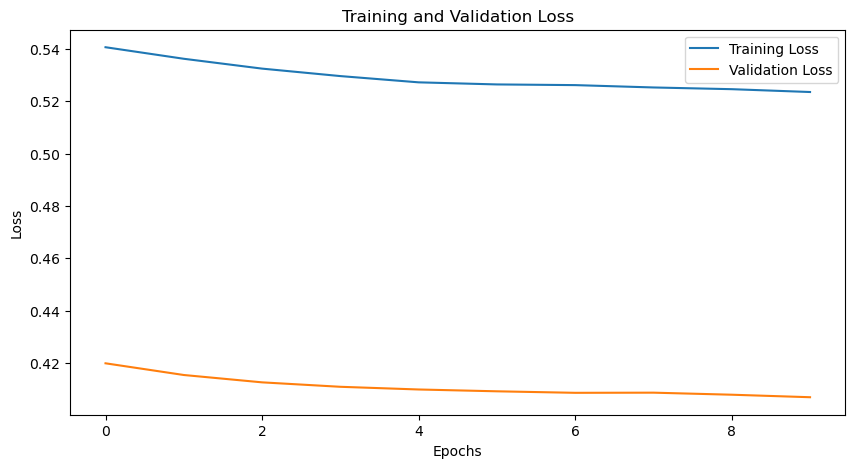

CPU times: user 5.86 s, sys: 160 ms, total: 6.02 s
Wall time: 5.19 s


In [208]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
# input_dim = 128*5+1
input_dim = stock_number
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=1,
    # output_dim=len(train_dataset.target_columns),
    output_dim=9,
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()
# criterion = nn.MSELoss()

train_losses = []
val_losses = []

num_epochs = 10
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
total_batches = num_epochs * len(train_dataloader)
total_start_time = time.time()

for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    batch_start_time = time.time()
    
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 20 == 0:
            # print(f"Batch {i}, Loss: {loss}, train_loss: {running_loss}")
            elapsed_time = time.time() - batch_start_time
            remaining_batches = len(train_dataloader) - (i + 1)
            estimated_remaining_time_epoch = remaining_batches * (elapsed_time / (i + 1))
            
            total_elapsed_time = time.time() - total_start_time
            total_remaining_batches = total_batches - ((epoch * len(train_dataloader)) + (i + 1))
            estimated_remaining_time_total = total_remaining_batches * (total_elapsed_time / ((epoch * len(train_dataloader)) + (i + 1)))

            print(f"Batch {i}/{len(train_dataloader)}, Loss: {loss:.4f}, "
                  f"Estimated time left for epoch: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_epoch))}, "
                  f"Estimated time left for training: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_total))}")
            
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Plot Prediction vs True Values (scaler.inverse_transform)

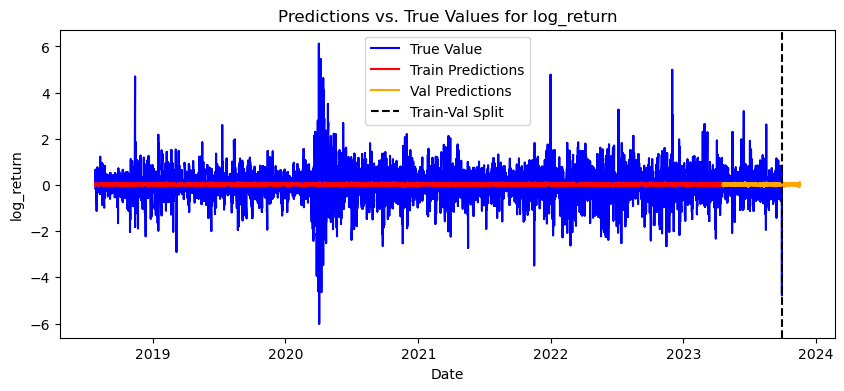

In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

# Assuming the model and dataloaders are already defined and trained
# Also assuming the standardized_data is available

# Separate scaler for target columns
target_scaler = StandardScaler()
standardized_data[train_dataset.target_columns] = target_scaler.fit_transform(standardized_data[train_dataset.target_columns])

# Function to get predictions
def get_predictions(dataloader, model, device):
    model.eval()
    predictions = []
    true_values = []
    with torch.no_grad():
        for batch in dataloader:
            features = batch["features"].to(device)
            target = batch["target"].to(device)
            output, _ = model(features)
            # print(output.shape)
            predictions.append(output.cpu().numpy())
            true_values.append(target.cpu().numpy())
    return np.concatenate(predictions), np.concatenate(true_values)

# Get predictions for training and validation datasets
train_predictions, train_true_values = get_predictions(train_dataloader, model, device)
val_predictions, val_true_values = get_predictions(val_dataloader, model, device)

# Reshape predictions and true values to 2D arrays
train_predictions = train_predictions.reshape(-1, len(train_dataset.target_columns))
train_true_values = train_true_values.reshape(-1, len(train_dataset.target_columns))
val_predictions = val_predictions.reshape(-1, len(val_dataset.target_columns))
val_true_values = val_true_values.reshape(-1, len(val_dataset.target_columns))

# Inverse transform the predictions and true values using target_scaler
train_predictions = target_scaler.inverse_transform(train_predictions)
train_true_values = target_scaler.inverse_transform(train_true_values)
val_predictions = target_scaler.inverse_transform(val_predictions)
val_true_values = target_scaler.inverse_transform(val_true_values)

# Convert predictions and true values to DataFrame
train_predictions_df = pd.DataFrame(train_predictions, columns=train_dataset.target_columns)
train_true_values_df = pd.DataFrame(train_true_values, columns=train_dataset.target_columns)
val_predictions_df = pd.DataFrame(val_predictions, columns=val_dataset.target_columns)
val_true_values_df = pd.DataFrame(val_true_values, columns=val_dataset.target_columns)

# Ensure the date columns have matching lengths
train_dates = train_data.iloc[window_size:len(train_predictions) + window_size]['date'].values
if len(train_dates) < len(train_predictions_df):
    train_dates = np.append(train_dates, [train_dates[-1]] * (len(train_predictions_df) - len(train_dates)))
train_predictions_df['date'] = train_dates
train_true_values_df['date'] = train_dates

val_dates = validation_data.iloc[window_size:len(val_predictions) + window_size]['date'].values
if len(val_dates) < len(val_predictions_df):
    val_dates = np.append(val_dates, [val_dates[-1]] * (len(val_predictions_df) - len(val_dates)))
val_predictions_df['date'] = val_dates
val_true_values_df['date'] = val_dates

# Plotting function for each label
def plot_predictions_vs_true(label):
    plt.figure(figsize=(10, 4))

    # Plot the train data
    plt.plot(train_true_values_df['date'], train_true_values_df[label], label='True Value', color='blue')

    plt.plot(train_predictions_df['date'], train_predictions_df[label], label='Train Predictions', color='red')
    plt.plot(val_predictions_df['date'], val_predictions_df[label], label='Val Predictions', color='orange')

    plt.axvline(x=pd.to_datetime('2023-09-30'), color='black', linestyle='--', label='Train-Val Split')

    plt.xlabel('Date')
    plt.ylabel(label)
    plt.title(f'Predictions vs. True Values for {label}')
    plt.legend()
    plt.show()

# Plot for all labels
for label in train_dataset.target_columns:
    plot_predictions_vs_true(label)


#### Input Embedding Weights

In [210]:
input_embedding_weights = model.input_embedding.weight.detach().cpu().numpy().T
print(input_embedding_weights)

[[-0.23835234  0.31145525 -0.19223042 ...  0.11191619  0.07528034
  -0.21086586]
 [-0.10243544  0.04161654  0.1867054  ... -0.1761237   0.17868726
  -0.17006536]
 [-0.28481042 -0.27046686  0.01755013 ... -0.11093742 -0.10761043
  -0.30145743]
 ...
 [ 0.13354844  0.29893297  0.14708227 ... -0.13532707 -0.16124202
  -0.06661022]
 [ 0.09551932 -0.08499681  0.10399975 ...  0.12482854  0.0583469
  -0.02678592]
 [ 0.31441557 -0.17836376  0.23499404 ... -0.18410452 -0.29829448
  -0.20975168]]


In [211]:
input_embedding_weights.shape

(9, 256)

In [212]:
cosine_sim_matrix_input_embedding_weights = cosine_similarity(input_embedding_weights)
cosine_sim_matrix_input_embedding_weights

array([[ 0.99999976, -0.11929696,  0.09771678, -0.01592519, -0.07794976,
         0.00161539, -0.03378431,  0.00129666, -0.06306373],
       [-0.11929696,  0.99999994, -0.09700744,  0.18030246, -0.05813112,
         0.00497479,  0.05434528, -0.03682928,  0.07885062],
       [ 0.09771678, -0.09700744,  1.        ,  0.09113446,  0.01589723,
         0.01551944,  0.03727308, -0.06418027,  0.13925172],
       [-0.01592519,  0.18030246,  0.09113446,  0.99999994, -0.05997363,
        -0.0562629 ,  0.05136466, -0.06136905,  0.12476384],
       [-0.07794976, -0.05813112,  0.01589723, -0.05997363,  0.9999996 ,
         0.05421837,  0.002368  ,  0.03710116, -0.09204578],
       [ 0.00161539,  0.00497479,  0.01551944, -0.0562629 ,  0.05421837,
         0.9999999 ,  0.0349557 ,  0.06092129, -0.02495068],
       [-0.03378431,  0.05434528,  0.03727308,  0.05136466,  0.002368  ,
         0.0349557 ,  0.99999964,  0.03423619,  0.19325161],
       [ 0.00129666, -0.03682928, -0.06418027, -0.06136905,  0

In [213]:
# pd.DataFrame(cosine_sim_matrix_input_embedding_weights).to_csv("cosine_sim_matrix_input_embedding_weights554_3.csv")

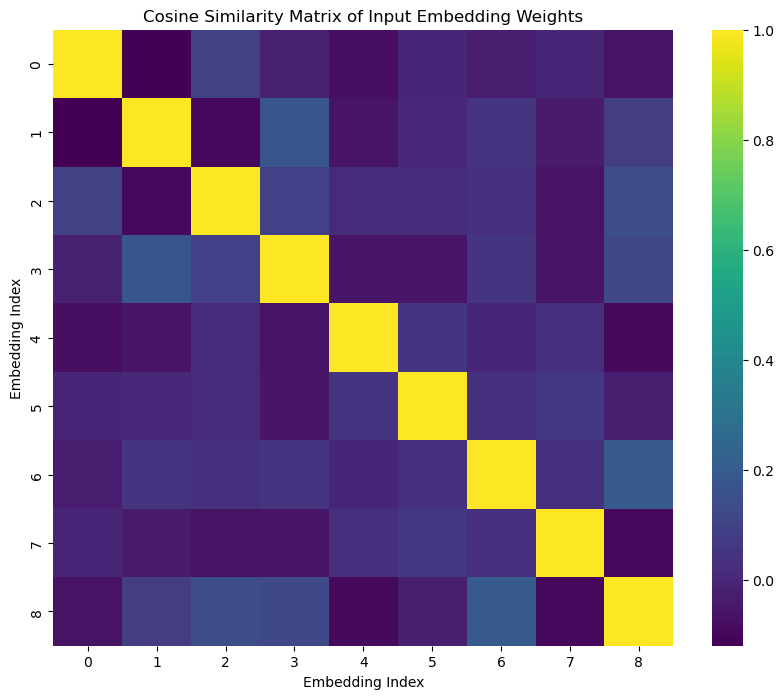

In [214]:
# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix_input_embedding_weights, annot=False, cmap='viridis')
plt.title('Cosine Similarity Matrix of Input Embedding Weights')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')
plt.show()

In [224]:
fc_weights = model.fc.weight.detach().cpu().numpy()
print(fc_weights)

[[ 0.05945629  0.07520319  0.05881785 ... -0.02188217 -0.03669623
  -0.03112892]
 [-0.05652042  0.06020259  0.08390985 ... -0.03151129 -0.0001736
  -0.02797225]
 [-0.06442559  0.04555084  0.05484496 ...  0.00748059 -0.0221879
  -0.00413164]
 ...
 [-0.02172153 -0.07352881 -0.0453211  ... -0.00592967 -0.06237199
  -0.0548532 ]
 [-0.06246722  0.03472582  0.04855071 ...  0.04272428 -0.03321707
  -0.07995935]
 [ 0.02848371  0.00154994  0.03665474 ...  0.02936884  0.08331934
  -0.07879125]]


In [225]:
fc_weights.shape

(9, 128)

In [226]:
cosine_sim_matrix_fc_weights = cosine_similarity(fc_weights)
cosine_sim_matrix_fc_weights

array([[ 0.99999976,  0.02056496, -0.04265371, -0.04807932, -0.04558558,
         0.17423749, -0.12956032,  0.08290727, -0.0925189 ],
       [ 0.02056496,  1.0000002 ,  0.18584315,  0.06517643,  0.13530642,
        -0.09725048, -0.01580707, -0.04605279,  0.0334185 ],
       [-0.04265371,  0.18584315,  1.0000001 ,  0.14971738, -0.01379627,
        -0.03080404, -0.04304894,  0.06825913,  0.15409034],
       [-0.04807932,  0.06517643,  0.14971738,  1.0000002 , -0.01489991,
         0.05671079, -0.01525025,  0.15880994,  0.12472105],
       [-0.04558558,  0.13530642, -0.01379627, -0.01489991,  0.9999998 ,
        -0.16986227,  0.09487676, -0.09387673, -0.02786423],
       [ 0.17423749, -0.09725048, -0.03080404,  0.05671079, -0.16986227,
         0.99999994,  0.04463226,  0.00444714,  0.06091499],
       [-0.12956032, -0.01580707, -0.04304894, -0.01525025,  0.09487676,
         0.04463226,  1.0000001 ,  0.10455373,  0.05982062],
       [ 0.08290727, -0.04605279,  0.06825913,  0.15880994, -0

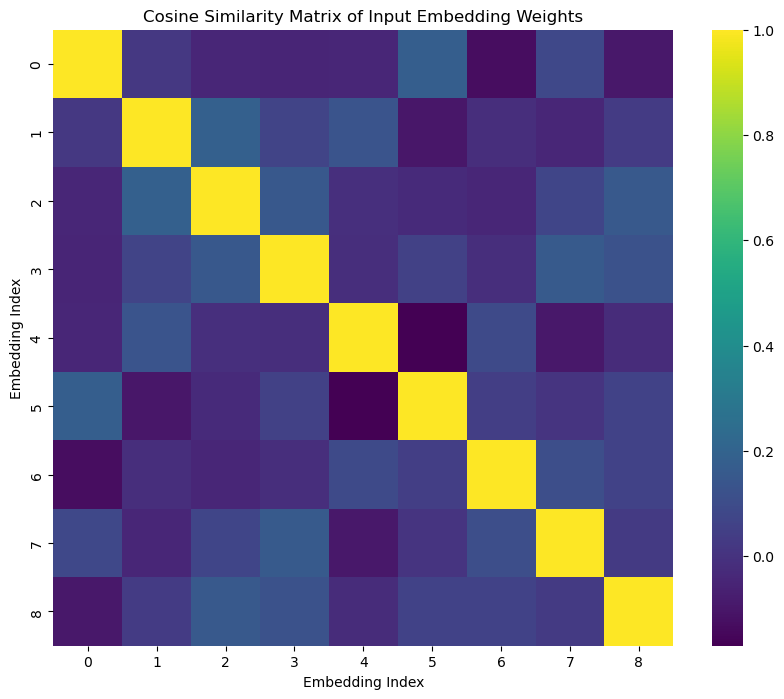

In [227]:
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix_fc_weights, annot=False, cmap='viridis')
plt.title('Cosine Similarity Matrix of Input Embedding Weights')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')
plt.show()

#### Feed_Forward Weights

In [ ]:
# To get the weights of the first encoder layer
encoder_layer_weights = model.transformer.layers[0].state_dict()
encoder_layer_weights

In [ ]:
# If you want to get the weights of all encoder layers
all_encoder_layers_weights = [layer.state_dict() for layer in model.transformer.layers]
all_encoder_layers_weights

In [ ]:
# Attention weights
attention_weights = encoder_layer_weights['self_attn.in_proj_weight']

# Feedforward weights
feedforward_weights = encoder_layer_weights['linear1.weight']

print("Attention Weights:", attention_weights.shape)
print("Feedforward Weights:", feedforward_weights.shape)


In [ ]:
feedforward_weights_matrix = feedforward_weights.cpu().numpy()
feedforward_weights_matrix

In [ ]:
cosine_sim_matrix_feedforward_weights = cosine_similarity(feedforward_weights_matrix)
cosine_sim_matrix_feedforward_weights

In [ ]:
# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix_feedforward_weights, annot=False, cmap='viridis')
plt.title('Cosine Similarity Matrix of Input Embedding Weights')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')
plt.show()

#### Extract Last Output Embedding

In [215]:

with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))

In [217]:
# output_embedding_matrix = embeddings[:,-1,:].cpu().numpy()
output_embedding_matrix = embeddings.cpu().numpy()
output_embedding_matrix

array([[-1.2106125 ,  0.6426137 , -0.7192055 , ...,  0.15665479,
         1.8928071 , -1.1801013 ],
       [ 0.661642  ,  0.86882323, -2.0215986 , ...,  0.06158398,
        -0.08396879,  0.6037251 ],
       [ 0.02973475,  0.38543847, -0.30752924, ...,  0.28763542,
         0.7085864 , -1.1281939 ],
       [ 1.9342909 ,  0.3753687 ,  1.2694846 , ..., -1.434323  ,
        -0.00251319, -2.1248338 ],
       [ 1.540131  ,  1.6433718 , -0.7021902 , ...,  0.34267542,
         0.41227296, -1.0146788 ],
       [ 1.8806067 ,  0.7619664 , -0.41642633, ..., -0.5737233 ,
         0.8113065 , -0.83432853]], dtype=float32)

In [219]:
output_embedding_matrix.shape

(6, 256)

In [220]:
cosine_sim_matrix_out_embedding = cosine_similarity(output_embedding_matrix)
cosine_sim_matrix_out_embedding

array([[ 1.0000002 ,  0.04982822,  0.30839905,  0.01302533,  0.40776688,
         0.37624258],
       [ 0.04982822,  0.99999994,  0.26383144, -0.1823884 ,  0.43409544,
         0.5925679 ],
       [ 0.30839905,  0.26383144,  1.0000001 ,  0.11018618,  0.09094997,
         0.2055488 ],
       [ 0.01302533, -0.1823884 ,  0.11018618,  1.        ,  0.14627986,
         0.45100585],
       [ 0.40776688,  0.43409544,  0.09094997,  0.14627986,  1.0000005 ,
         0.6057283 ],
       [ 0.37624258,  0.5925679 ,  0.2055488 ,  0.45100585,  0.6057283 ,
         0.9999997 ]], dtype=float32)

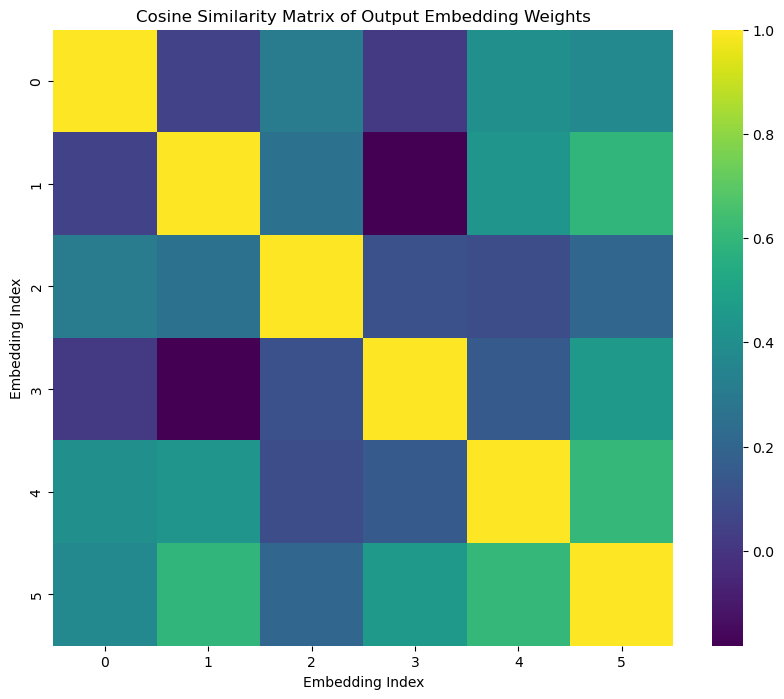

In [221]:
# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix_out_embedding, annot=False, cmap='viridis')
plt.title('Cosine Similarity Matrix of Output Embedding Weights')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')
plt.show()

#### Average Output Embedding

In [151]:
# Initialize an empty tensor to accumulate the embeddings
accumulated_embeddings = torch.zeros(128, 256).to(device)
total_batches = 0

with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        #print(embeddings)
        accumulated_embeddings += embeddings.sum(dim=1)
        # total_batches += batch["features"].size(0)
        total_batches += embeddings.size(1)

# Divide the accumulated embeddings by the total number of batches to get the average
average_embeddings = accumulated_embeddings / total_batches
print(total_batches)
average_embeddings

1318


tensor([[-0.4820,  0.9984, -0.8813,  ...,  0.2737, -0.0311, -0.2805],
        [-0.4820,  0.9987, -0.8826,  ...,  0.2737, -0.0322, -0.2787],
        [-0.4814,  0.9997, -0.8820,  ...,  0.2739, -0.0329, -0.2793],
        ...,
        [-0.4874,  0.9883, -0.8951,  ...,  0.2698, -0.0245, -0.2782],
        [-0.4870,  0.9878, -0.8939,  ...,  0.2699, -0.0241, -0.2787],
        [-0.4863,  0.9875, -0.8936,  ...,  0.2704, -0.0248, -0.2781]],
       device='cuda:0')

In [152]:
average_embeddings.shape

torch.Size([128, 256])

In [153]:
batch["features"].shape

torch.Size([6, 128, 9])

In [154]:
batch["features"].size(0)

6

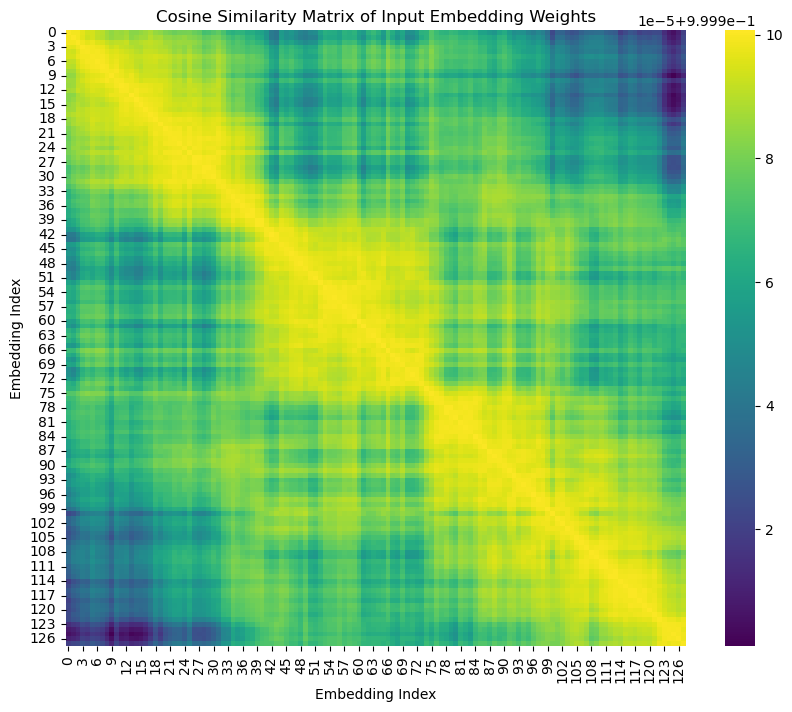

In [155]:
# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_similarity(average_embeddings.cpu().numpy()), annot=False, cmap='viridis')
plt.title('Cosine Similarity Matrix of Input Embedding Weights')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')
plt.show()